In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import time

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
year_now = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'Last date of dataset is: {year_now}')

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days = 365)
print(f'Date one year ago was: {year_ago}')

# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date
year_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()
year_prcp

# Save the query results as a Pandas DataFrame and set the index to the date column
year_prcp_df = pd.DataFrame(year_prcp).set_index('date')
year_prcp_df.head()

Last date of dataset is: ('2017-08-23',)
Date one year ago was: 2016-08-23


,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


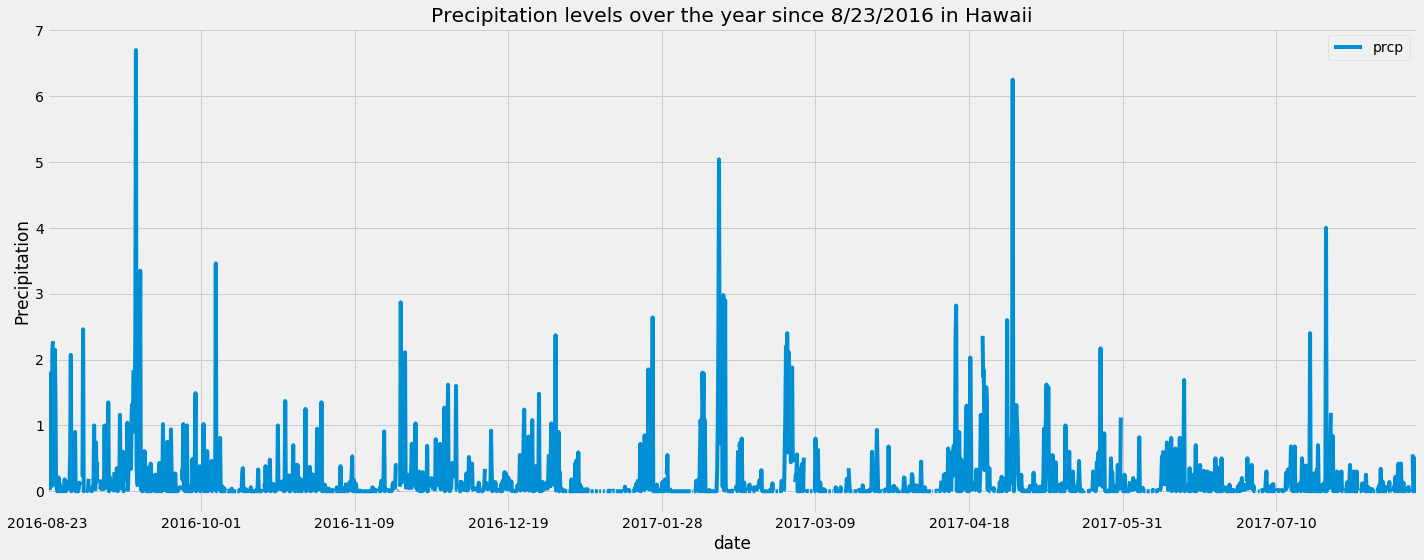

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
year_prcp_df.plot(figsize = (20,8))
plt.title("Precipitation levels over the year since 8/23/2016 in Hawaii")
plt.ylabel('Precipitation')
plt.tight_layout()
plt.savefig("Resources/01_preciptation_year.png")
plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Measurement.station.distinct())).all()
print(f'There are {stations} stations.')

There are [(9,)] stations.


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,
      func.count(Measurement.station)]
active_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel2 = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

session.query(*sel2).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

Last date of temp observation for USC00519281 was: ('2017-08-18',)
Date one year ago was for USC00519281: 2016-08-18


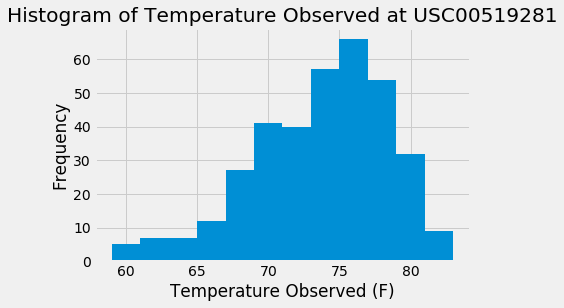

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = session.query(Measurement.date).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.desc()).first()
print(f'Last date of temp observation for USC00519281 was: {last_date}')

year_last = dt.date(2017, 8, 18) - dt.timedelta(days = 365)
print(f'Date one year ago was for USC00519281: {year_last}')

sel3 = [Measurement.date,
       Measurement.tobs]

highest_no_temp = session.query(*sel3).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= year_last).all()
highest_no_temp

# convert to df
highest_no_temp_df = pd.DataFrame(highest_no_temp)
highest_no_temp_df
# histogram
x = highest_no_temp_df['tobs']
num_bins = 12
plt.hist(x, num_bins)
plt.title("Histogram of Temperature Observed at USC00519281")
plt.ylabel('Frequency')
plt.xlabel('Temperature Observed (F)')
plt.savefig("Resources/02_histogram.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
t_results = calc_temps('2017-08-10','2017-08-23')
print(t_results)

[(70.0, 78.71428571428571, 85.0)]


In [19]:
t_df = pd.DataFrame(t_results, columns =['tmin','tavg','tmax'])
t_df

,tmin,tavg,tmax
0,70.0,78.714286,85.0


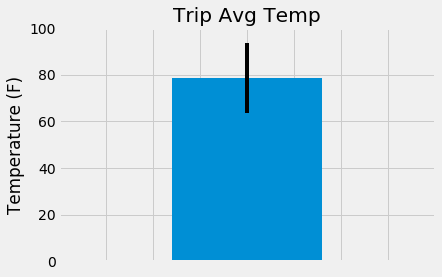

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
yerr = t_df['tmax']-t_df['tmin']
ax.bar(1, t_df['tavg'], yerr=yerr)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.xlim(0, 2)
plt.ylim(0,100)

#remove x labels
labels = [item.get_text() for item in ax.get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax.set_xticklabels(empty_string_labels)

plt.savefig("Resources/03_tripavgtemp.png")

plt.show()


In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
for m, s in session.query(Measurement, Station).filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2017-08-10').filter(Measurement.date <= '2017-08-23').\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all():
        print(m.station, s.name, s.latitude, s.longitude, s.elevation, m.prcp)

USC00516128 MANOA LYON ARBO 785.2, HI US 21.3331 -157.8025 152.4 0.07
USC00519281 WAIHEE 837.5, HI US 21.45167 -157.84888999999998 32.9 0.0
USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US 21.33556 -157.71139 19.5 0.0
USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 21.5213 -157.8374 7.0 0.0
USC00519397 WAIKIKI 717.2, HI US 21.2716 -157.8168 3.0 0.0


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
